In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install -q tensorflow-io
!pip install pydicom
!pip install scikit-image

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_io as tfio

In [8]:
train_csv = pd.read_csv("/kaggle/input/osic-pulmonary-fibrosis-progression/train.csv")
test_csv = pd.read_csv("/kaggle/input/osic-pulmonary-fibrosis-progression/test.csv")
print("TRAIN DATA: \n", train_csv.head())
print("TEST DATA: \n", test_csv.head())

TRAIN DATA: 
                      Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker
TEST DATA: 
                      Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00419637202311204720264      6  3020  70.186855   73  Male     Ex-smoker
1  ID00421637202311550012437     15  2739  82.045291   68  Male     Ex-smoker
2  ID00422637202311677017371      6  1930  76.672493   73  Male     Ex-smoker
3  ID00423637202312137826377     17  3294  79.258903   72  Male     Ex-smoker
4  ID00426637202313170790466      0  2925  71.824968   73  Male  Never smoked


In [9]:
print("Number of examples in Train data: ", len(train_csv))
print("Number of examples in Test data: ", len(test_csv))

num_patients = len(train_csv.Patient.unique())
print("\nNumber of unique patients: ", num_patients)

Number of examples in Train data:  1549
Number of examples in Test data:  5

Number of unique patients:  176


In [10]:
train_data = train_csv.groupby("Patient")
first_occurrence = train_data.first()

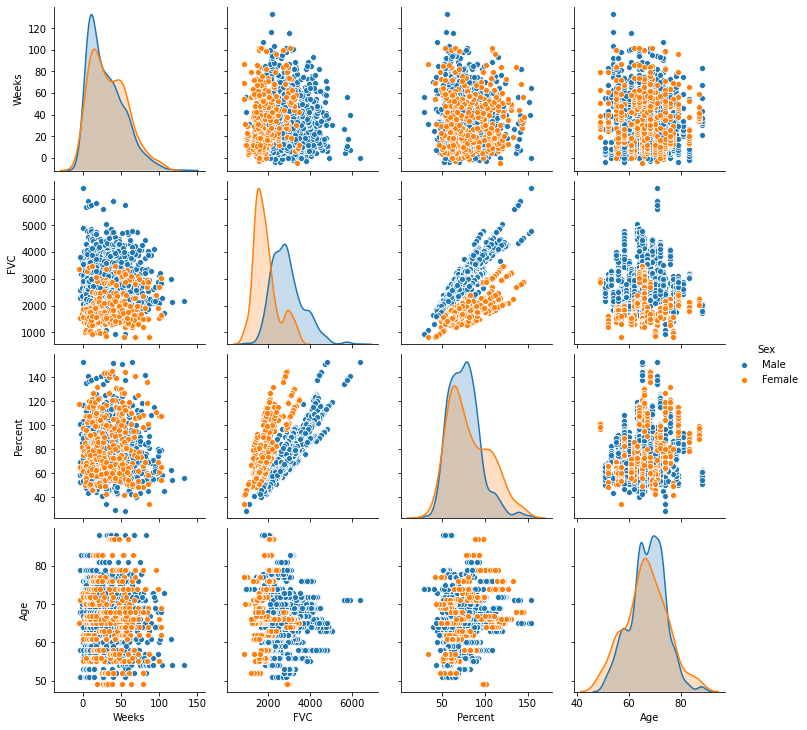

In [11]:
sns.pairplot(train_csv, hue='Sex')

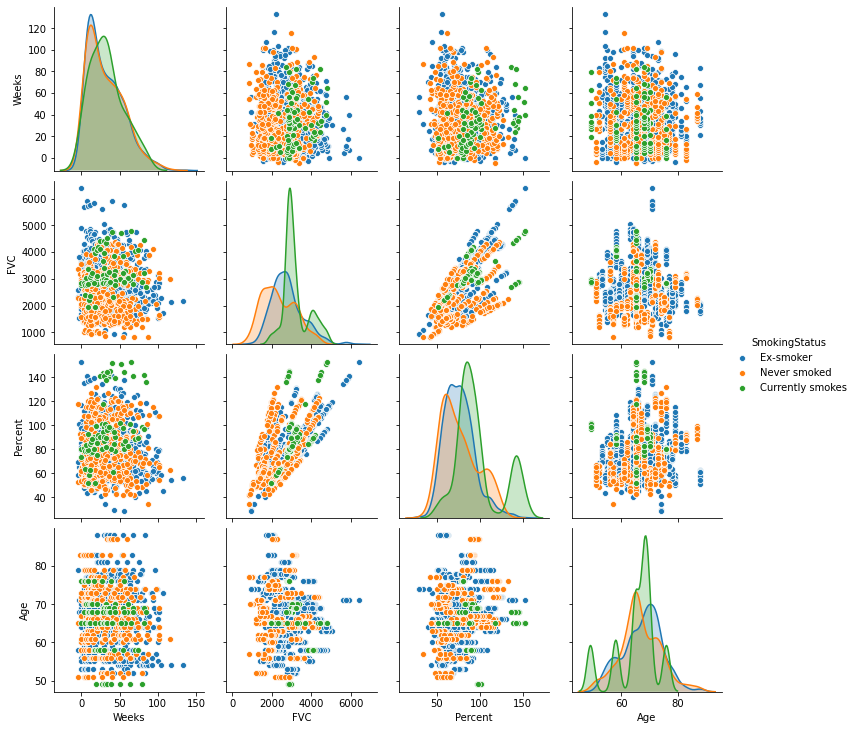

In [12]:
sns.pairplot(train_csv, hue='SmokingStatus')

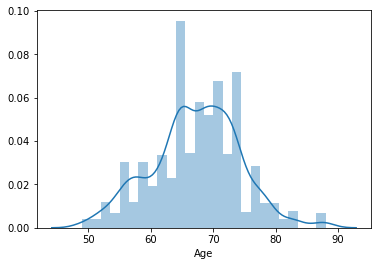

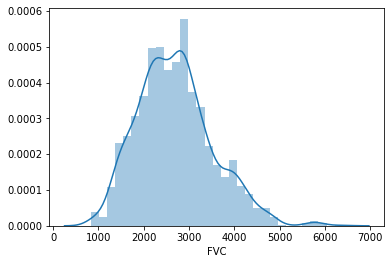

In [24]:
plt.figure()
sns.distplot(train_csv['Age'], hist=True, kde=True)
plt.figure()
sns.distplot(train_csv['FVC'], hist=True, kde=True)
plt.figure()
sns.distplot(train_csv['Percent'], hist=True, kde=True)

Lowest Age:  49
Highest Age:  88


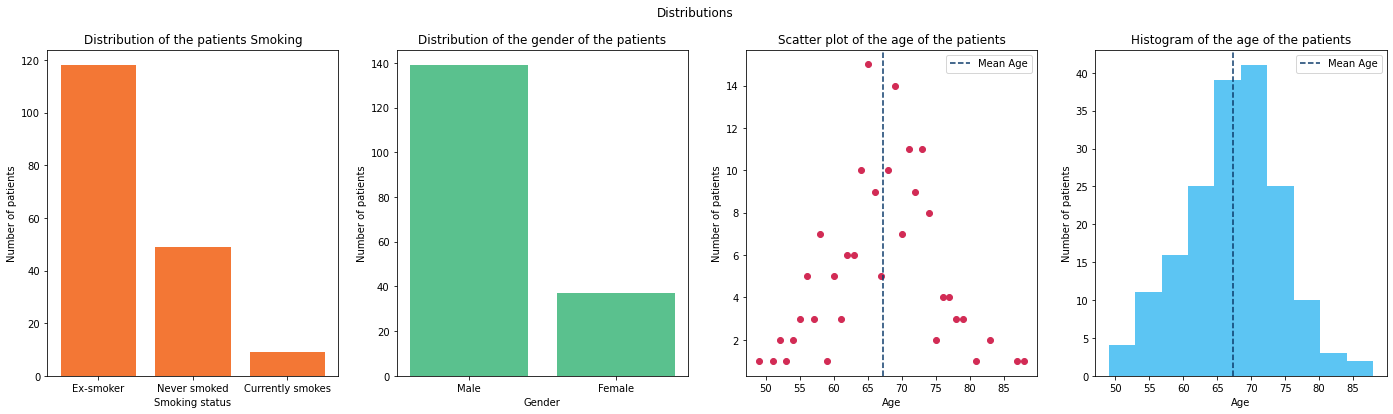

In [13]:
## DEMOGRAPHICS OF PATIENTS

# SMOKING STATUS 
smoking_status = first_occurrence["SmokingStatus"]
smoking_labels = smoking_status.value_counts().index.tolist()
smoking_counts = smoking_status.value_counts().tolist()

# SEX
gender_status = first_occurrence["Sex"]
gender_labels = gender_status.value_counts().index.tolist()
gender_counts = gender_status.value_counts().tolist()

# AGE
age = first_occurrence["Age"]
age_labels = age.value_counts().index.tolist()
age_counts = age.value_counts().tolist()

print("Lowest Age: ", age.min())
print("Highest Age: ", age.max())

# PLOTTING THE DISTRIBUTIONS
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (24, 6))

# Bar graph of the distribution of the smoking status
ax1.bar([1,2,3], smoking_counts, tick_label=smoking_labels, color="#f37735")
ax1.set_title("Distribution of the patients Smoking")
ax1.set_xlabel("Smoking status")
ax1.set_ylabel("Number of patients")

# Bar graph of the distribution of the gender
ax2.bar([1,2], gender_counts, tick_label=gender_labels, color="#5ac18e")
ax2.set_title("Distribution of the gender of the patients")
ax2.set_xlabel("Gender")
ax2.set_ylabel("Number of patients")

# Scatter plot of the age of the patients vs number of patients
ax3.scatter(age_labels, age_counts, color="#d22b55")
ax3.axvline(age.mean(), label="Mean Age", color="#0c3b6a", linestyle='--')
ax3.set_title("Scatter plot of the age of the patients")
ax3.set_xlabel("Age")
ax3.set_ylabel("Number of patients")
ax3.legend()

# Histogram of the Age
ax4.hist(age.tolist(), bins=10, color="#5cc5f3")
ax4.axvline(age.mean(), label="Mean Age", color="#0c3b6a", linestyle='--')
ax4.set_title("Histogram of the age of the patients")
ax4.set_xlabel("Age")
ax4.set_ylabel("Number of patients")
ax4.legend()

fig.suptitle("Distributions")
plt.show()

Max FVC value:  6399
Min FVC value:  827
Mean FVC value:  2690.479018721756

Max Percent value:  153.145377828922
Min Percent value:  28.877576671694303
Mean Percent value:  77.67265350296324

Max week:  133
Min week:  -5
Mean number of week:  31.861846352485475

Max visits:  10
Min visits:  6
Mean number of vsits:  8.801136363636363


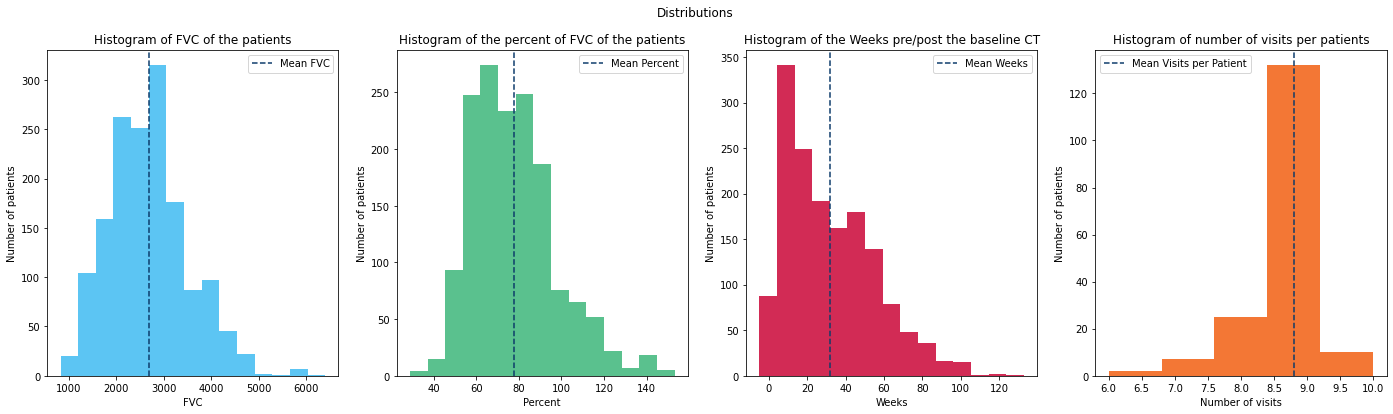

In [14]:
# HISTOGRAMS

# FVC - the recorded lung capacity in ml
fvc = train_csv["FVC"]

print("Max FVC value: ", fvc.max())
print("Min FVC value: ", fvc.min())
print("Mean FVC value: ", fvc.mean())

# PERCENT -  a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics
percent = train_csv["Percent"]

print("\nMax Percent value: ", percent.max())
print("Min Percent value: ", percent.min())
print("Mean Percent value: ", percent.mean())

# WEEKS - the relative number of weeks pre/post the baseline CT
weeks = train_csv["Weeks"]

print("\nMax week: ", weeks.max())
print("Min week: ", weeks.min())
print("Mean number of week: ", weeks.mean())

# VISITS PER PATIENT
visits_per_patient = train_csv['Patient'].value_counts()
print("\nMax visits: ", visits_per_patient.max())
print("Min visits: ", visits_per_patient.min())
print("Mean number of vsits: ", visits_per_patient.mean())

# PLOTTING THE HISTOGRAMS
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (24, 6))

# Histogram of the FVC
ax1.hist(fvc.tolist(), bins=15, color="#5cc5f3")
ax1.axvline(fvc.mean(), label="Mean FVC", color="#0c3b6a", linestyle='--')
ax1.set_title("Histogram of FVC of the patients")
ax1.set_xlabel("FVC")
ax1.set_ylabel("Number of patients")
ax1.legend()

# Histogram of the Percent 
ax2.hist(percent.tolist(), bins=15, color="#5ac18e")
ax2.axvline(percent.mean(), label="Mean Percent", color="#0c3b6a", linestyle='--')
ax2.set_title("Histogram of the percent of FVC of the patients")
ax2.set_xlabel("Percent")
ax2.set_ylabel("Number of patients")
ax2.legend()

# Histogram of the Weeks
ax3.hist(weeks.tolist(), bins=15, color="#d22b55")
ax3.axvline(weeks.mean(), label="Mean Weeks", color="#0c3b6a", linestyle='--')
ax3.set_title("Histogram of the Weeks pre/post the baseline CT")
ax3.set_xlabel("Weeks")
ax3.set_ylabel("Number of patients")
ax3.legend()

# Histogram of the Visits per patient
ax4.hist(visits_per_patient.tolist(), bins=5, color="#f37735")
ax4.axvline(visits_per_patient.mean(), label="Mean Visits per Patient", color="#0c3b6a", linestyle='--')
ax4.set_title("Histogram of number of visits per patients")
ax4.set_xlabel("Number of visits")
ax4.set_ylabel("Number of patients")
ax4.legend()


fig.suptitle("Distributions")
plt.show()

Pearson correlation between the features:
             Weeks       FVC   Percent       Age
Weeks    1.000000 -0.041447 -0.012536 -0.059473
FVC     -0.041447  1.000000  0.671964 -0.094125
Percent -0.012536  0.671964  1.000000  0.095949
Age     -0.059473 -0.094125  0.095949  1.000000


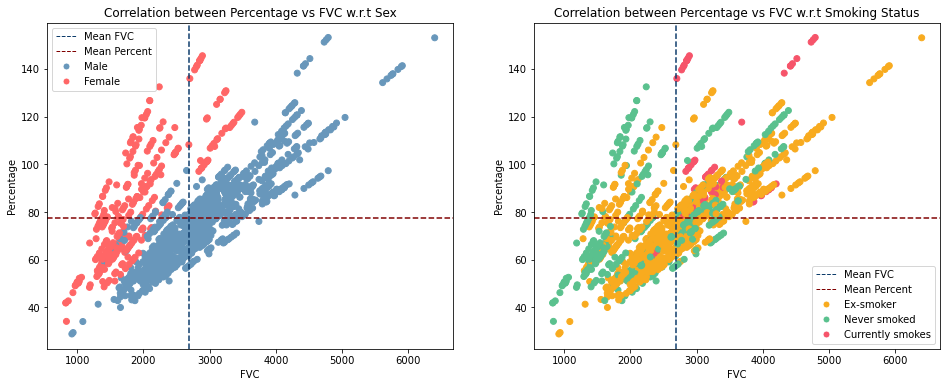

In [15]:
# PEARSON CORRELATION BETWEEN THE COLUMNS
print("Pearson correlation between the features:\n",train_csv.corr(method='pearson'))
from matplotlib.lines import Line2D

gender_colors={"Male": "#6897bb", "Female":"#ff6666"}
smoker_colors={"Ex-smoker":"#f8ab1f", "Never smoked":"#5ac18e", "Currently smokes":"#f6546a"}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

# Scatter plot of FVC vs Percent with Sex as the labels 
ax1.scatter(fvc.tolist(), percent.tolist(), c=train_csv["Sex"].apply(lambda x: gender_colors[x]))
ax1.axvline(fvc.mean(), label="Mean FVC", color="#0c3b6a", linestyle='--')
ax1.axhline(percent.mean(), label="Mean Percent", color="#800000", linestyle='--')
ax1.set_title("Correlation between Percentage vs FVC w.r.t Sex")
ax1.set_xlabel("FVC")
ax1.set_ylabel("Percentage")

legend_elements = [Line2D([0], [0], color='#0c3b6a', linestyle='--', lw=1, label='Mean FVC'),
                   Line2D([0], [0], color='#800000', linestyle='--', lw=1, label='Mean Percent'),
                   Line2D([0], [0], marker='o', color='w', label='Male', markerfacecolor='#6897bb', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='Female', markerfacecolor='#ff6666', markersize=7)]
ax1.legend(handles=legend_elements)

# Scatter plot of FVC vs Percent with Smoking status as the labels
ax2.scatter(fvc.tolist(), percent.tolist(), c=train_csv["SmokingStatus"].apply(lambda x: smoker_colors[x]))
ax2.axvline(fvc.mean(), label="Mean FVC", color="#0c3b6a", linestyle='--')
ax2.axhline(percent.mean(), label="Mean Percent", color="#800000", linestyle='--')
ax2.set_title("Correlation between Percentage vs FVC w.r.t Smoking Status")
ax2.set_xlabel("FVC")
ax2.set_ylabel("Percentage")

legend_elements = [Line2D([0], [0], color='#0c3b6a', linestyle='--', lw=1, label='Mean FVC'),
                   Line2D([0], [0], color='#800000', linestyle='--', lw=1, label='Mean Percent'),
                   Line2D([0], [0], marker='o', color='w', label='Ex-smoker', markerfacecolor='#f8ab1f', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='Never smoked', markerfacecolor='#5ac18e', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='Currently smokes', markerfacecolor='#f6546a', markersize=7)]
ax2.legend(handles=legend_elements)

plt.show()

TypeError: Invalid shape (0,) for image data

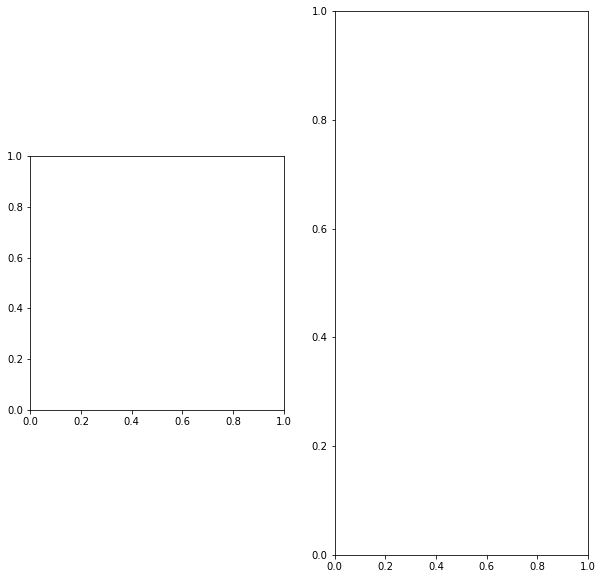

In [16]:
filename = '/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00422637202311677017371/45.dcm'
image_bytes = tf.io.read_file(filename)

image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)
skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)
lossy_image = tfio.image.decode_dicom_image(image_bytes, scale='auto', on_error='lossy', dtype=tf.uint8)


fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(np.squeeze(image.numpy()), cmap='gray')
axes[0].set_title('image')
axes[1].imshow(np.squeeze(lossy_image.numpy()), cmap='gray')
axes[1].set_title('lossy image')